# Import


In [ ]:
# Some libraries are redundant

from IPython.core.interactiveshell import InteractiveShell
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import os

from PIL import Image
from torchsummary import summary
from timeit import default_timer as timer
!pip install memory_profiler
from memory_profiler import memory_usage
import time

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

import imgaug as ia
from imgaug import augmenters as iaa

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support

In [ ]:
# local imports
from utility import get_memory_usage_and_runtime, auc_roc_curves, create_confusion_matrix, get_metrics
from data_preprocessing import  get_dataset

In [ ]:
# Move to gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Add your own path
data_path = '/content/drive/My Drive/Capstone 2023/Data/all_data.npz'
save_location = '/content/drive/My Drive/Capstone 2023/Saved Models/'

# Data Preprocessing

In [ ]:
def convert_to_tensors_and_get_data_loaders(data):
  '''
  For each traing, validation and test set, convert the numpy arrays to torch tensors and create dataloaders for train and validation sets.

  :@param data (list): List of x_train, x_val, x_test, y_train, y_val, y_test
  :@return train_loader, valid_loader (DataLoader): pytorch class
  :@return x_test, y_test torch tensors
  '''
  x_train_np, x_valid_np, x_test_np, y_train_np, y_valid_np, y_test_np = data

  x_train = torch.tensor(x_train_np, dtype=torch.float32).unsqueeze(1).to(device)
  x_test = torch.tensor(x_test_np, dtype=torch.float32).unsqueeze(1).to(device)
  x_valid = torch.tensor(x_valid_np, dtype=torch.float32).unsqueeze(1).to(device)

  y_train =  torch.tensor(y_train_np, dtype=torch.long).to(device)
  y_test =   torch.tensor(y_test_np, dtype=torch.long).to(device)
  y_valid =  torch.tensor(y_valid_np, dtype=torch.long).to(device)

  # create train loader and validation loader
  dataset_train = TensorDataset(x_train, y_train)
  train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)

  dataset_valid = TensorDataset(x_valid, y_valid)
  valid_loader = DataLoader(dataset_valid, batch_size=32, shuffle=True)

  return train_loader, valid_loader, x_test, y_test

In [ ]:
# Original Data
train_loader_o, valid_loader_o, x_test_o, y_test_o = convert_to_tensors_and_get_data_loaders(get_dataset(use_external=False, aug_data=False))

# Original Data + Augmented Data to Train
train_loader_a, valid_loader_a, x_test_a, y_test_a = convert_to_tensors_and_get_data_loaders(get_dataset(use_external=False, aug_data=True))

# Original Data + Augmented Data to Train + External Datasets to Train
train_loader_d, valid_loader_d, x_test_d, y_test_d = convert_to_tensors_and_get_data_loaders(get_dataset(use_external=True, aug_data=True))

In [ ]:
batch_size = 32

# Training Function

In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, n_epochs=20, max_epochs_stop=3):
    start = timer()
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_max_acc = 0
    history = []

    for epoch in range(1, n_epochs+1):

        # ------- STAGE 1: TRAINING ----------
        model.train()
        train_loss, valid_loss = 0, 0
        train_acc, valid_acc = 0, 0

        for data, target in train_loader:
            if train_on_gpu:
              data, target = data.cuda(), target.cuda()

            # Make predictions, get loss, gradient descent
            optimizer.zero_grad()
            output = model(data) # log probabilities
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0) # Average loss times num examples in batch

            # Calculate accuracy
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0) # Average accuracy times num examples in batch

        # ------- STAGE 2: VALIDATION ----------
        model.eval()
        with torch.no_grad():
            for data, target in valid_loader:
              if train_on_gpu:
                data, target = data.cuda(), target.cuda()

              # Make predictions, get loss
              output = model(data)
              loss = criterion(output, target)
              valid_loss += loss.item() * data.size(0)

              # Calculate accuracy
              _, pred = torch.max(output, dim=1)
              correct_tensor = pred.eq(target.data.view_as(pred))
              accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
              valid_acc += accuracy.item() * data.size(0)

        # ------- STAGE 3: ANALYZE RESULTS ----------
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)
        train_acc = train_acc / len(train_loader.dataset)
        valid_acc = valid_acc / len(valid_loader.dataset)
        history.append([train_loss, valid_loss, train_acc, valid_acc])

        print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
        print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

        # Check if best performing epoch
        if valid_loss < valid_loss_min:
          epochs_no_improve = 0
          valid_loss_min = valid_loss
          valid_best_acc = valid_acc
          best_epoch = epoch

        # If not, check if early stopping conditions met
        else:
          epochs_no_improve += 1

          # Early stopping
          if epochs_no_improve >= max_epochs_stop:
            print('\nEarly Stopping')
            epoch += 1
            break

    # Display summary stats
    total_time = timer() - start
    print(f'\nTotal epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.4f} and acc: {100 * valid_acc:.2f}%')
    print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.')

    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [ ]:
print(len(train_loader_d), len(train_loader_a), len(train_loader_o))
print(len(valid_loader_d), len(valid_loader_a), len(valid_loader_o))

1027 874 125
55 55 55


# Setup Pre-trained Model

In [ ]:
def get_pretrained_model(model_name, n_classes=2):
  # ResNet
  if model_name == 'resnet18':
    model = models.resnet18(pretrained=True)

    # freeze early layers
    for param in model.parameters():
      param.requires_grad = False

    # change first layer to accept grayscale
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # custom classifier --> or else it performs bad
    n_inputs = model.fc.in_features
    model.fc = nn.Sequential(
      nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
      nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

  # VGGNet-16
  elif model_name == 'vgg16':
    model = models.vgg16(pretrained=True)

    # freeze early layers
    for param in model.parameters():
      param.requires_grad = False

    # change first layer to accept grayscale
    model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # custom classifier
    n_inputs = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
      nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
      nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

  #AlexNet
  elif model_name == 'alexnet':
    model = models.alexnet(pretrained=True)

    # freeze early layers
    for param in model.parameters():
      param.requires_grad = False

    # change first layer to accept grayscale
    model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # custom classifier
    n_inputs = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
      nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
      nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

  # GoogLeNet
  elif model_name == 'googlenet':
    model = models.googlenet(pretrained=True)

    # freeze early layers
    for param in model.parameters():
      param.requires_grad = False

    # change first layer to accept grayscale and disable RGB normalization transformation
    model.conv1.conv = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.transform_input = False

    # custom classifier
    n_inputs = model.fc.in_features
    model.fc = nn.Sequential(
      nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
      nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

  # # Inceptionv3 #TODO NEED TO DEBUG
  # elif model_name == 'inception':
  #   model = models.inception_v3(pretrained=True)

  #   # freeze early layers
  #   for param in model.parameters():
  #     param.requires_grad = False

  #   # custom classifier
  #   n_inputs = model.fc.in_features
  #   model.fc = nn.Sequential(
  #     nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
  #     nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

  # return
  else:
    print('no model')
    return 0

  # Move to gpu to parallelize
  if train_on_gpu:
    model = model.to('cuda')

  # if multi_gpu:
  #   model = nn.DataParallel(model)

  return model

# ResNet-18

In [ ]:
batch_size = 64

## Original Data

In [ ]:
# initialize model
model_resnet18_o = get_pretrained_model('resnet18')
input_size = (1, 1024, 768)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_resnet18_o.parameters())

if multi_gpu:
    summary(
        model_resnet18_o.module,
        input_size=input_size,
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model_resnet18_o,
        input_size=input_size,
        batch_size=batch_size,
        device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 512, 384]           3,136
       BatchNorm2d-2         [64, 64, 512, 384]             128
              ReLU-3         [64, 64, 512, 384]               0
         MaxPool2d-4         [64, 64, 256, 192]               0
            Conv2d-5         [64, 64, 256, 192]          36,864
       BatchNorm2d-6         [64, 64, 256, 192]             128
              ReLU-7         [64, 64, 256, 192]               0
            Conv2d-8         [64, 64, 256, 192]          36,864
       BatchNorm2d-9         [64, 64, 256, 192]             128
             ReLU-10         [64, 64, 256, 192]               0
       BasicBlock-11         [64, 64, 256, 192]               0
           Conv2d-12         [64, 64, 256, 192]          36,864
      BatchNorm2d-13         [64, 64, 256, 192]             128
             ReLU-14         [64, 64, 2


Epoch: 1 	Training Loss: 0.1669 	Validation Loss: 0.1561
		Training Accuracy: 93.06%	 Validation Accuracy: 94.72%

Epoch: 2 	Training Loss: 0.1143 	Validation Loss: 0.0312
		Training Accuracy: 95.54%	 Validation Accuracy: 98.80%

Epoch: 3 	Training Loss: 0.0574 	Validation Loss: 0.0456
		Training Accuracy: 98.00%	 Validation Accuracy: 98.22%

Epoch: 4 	Training Loss: 0.0192 	Validation Loss: 0.0281
		Training Accuracy: 99.35%	 Validation Accuracy: 99.25%

Epoch: 5 	Training Loss: 0.0497 	Validation Loss: 0.0429
		Training Accuracy: 98.00%	 Validation Accuracy: 98.34%

Epoch: 6 	Training Loss: 0.0310 	Validation Loss: 0.0665
		Training Accuracy: 98.85%	 Validation Accuracy: 97.53%

Epoch: 7 	Training Loss: 0.0246 	Validation Loss: 0.0345
		Training Accuracy: 98.90%	 Validation Accuracy: 98.68%

Early Stopping

Total epochs: 8. Best epoch: 4 with loss: 0.0281 and acc: 98.68%
25.46 total seconds elapsed. 3.18 seconds per epoch.


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'ResNet18 (Original) Training and Validation Accuracies')

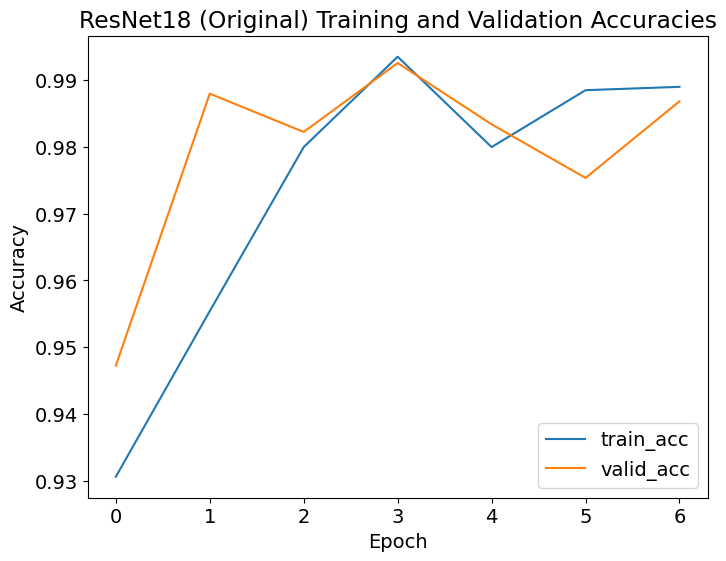

In [ ]:
# Train original and save

model_resnet18_o, history_resnet18_o = train(
    model_resnet18_o,
    criterion,
    optimizer,
    train_loader_o,
    valid_loader_o,
    n_epochs=15)

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(history_resnet18_o[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet18 (Original) Training and Validation Accuracies')

torch.save(model_resnet18_o.state_dict(), save_location+'resnet18_original_data.pth')

## Original + Augmented

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 1 	Training Loss: 0.1737 	Validation Loss: 0.0444
		Training Accuracy: 92.86%	 Validation Accuracy: 98.51%

Epoch: 2 	Training Loss: 0.0831 	Validation Loss: 0.1089
		Training Accuracy: 96.88%	 Validation Accuracy: 96.04%

Epoch: 3 	Training Loss: 0.0716 	Validation Loss: 0.0060
		Training Accuracy: 97.39%	 Validation Accuracy: 99.77%

Epoch: 4 	Training Loss: 0.0519 	Validation Loss: 0.0038
		Training Accuracy: 98.07%	 Validation Accuracy: 99.83%

Epoch: 5 	Training Loss: 0.0483 	Validation Loss: 0.0021
		Training Accuracy: 98.16%	 Validation Accuracy: 99.94%

Epoch: 6 	Training Loss: 0.0355 	Validation Loss: 0.0021
		Training Accuracy: 98.71%	 Validation Accuracy: 100.00%

Epoch: 7 	Training Loss: 0.0335 	Validation Loss: 0.0042
		Training Accuracy: 98.84%	 Validation Accuracy: 99.89%

Epoch: 8 	Training Loss: 0.0296 	Validation Loss: 0.0025
		Training Accuracy: 98.95%	 Validation Accuracy: 99.94%

Epoch: 9 	Training Loss: 0.0318 	Validation Loss: 0.0785
		Training Accuracy: 

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'ResNet18 (Original + Augmented Data) Training and Validation Accuracies')

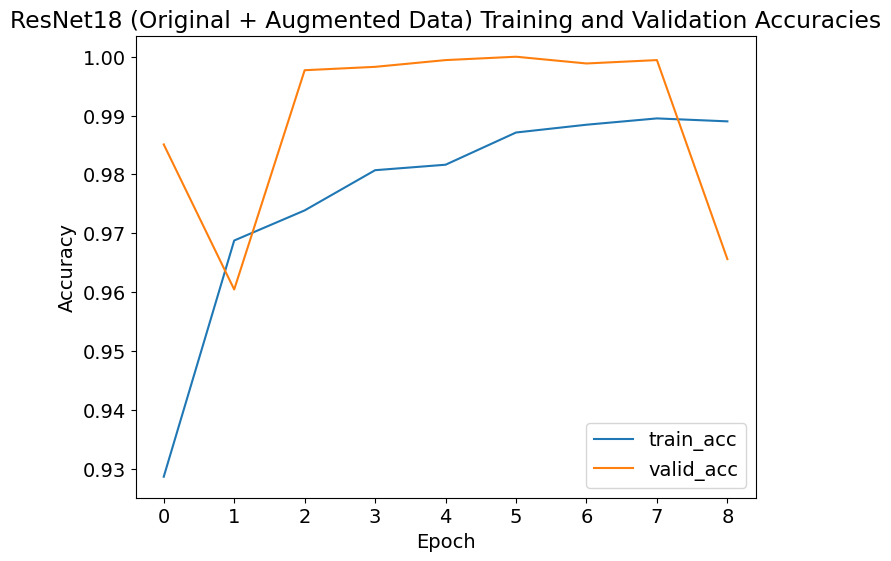

In [ ]:
# Train original + augmented and save
model_resnet18_a = get_pretrained_model('resnet18')
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_resnet18_a.parameters())

model_resnet18_a, history_resnet18_a = train(
    model_resnet18_a,
    criterion,
    optimizer,
    train_loader_a,
    valid_loader_a,
    n_epochs=15)

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(history_resnet18_a[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet18 (Original + Augmented Data) Training and Validation Accuracies')

torch.save(model_resnet18_a.state_dict(), save_location+'resnet18_original_plus_augmented_data.pth')

## Original + Augmented + External

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 1 	Training Loss: 0.1458 	Validation Loss: 0.0132
		Training Accuracy: 94.25%	 Validation Accuracy: 99.60%

Epoch: 2 	Training Loss: 0.0718 	Validation Loss: 0.0103
		Training Accuracy: 97.33%	 Validation Accuracy: 99.77%

Epoch: 3 	Training Loss: 0.0614 	Validation Loss: 0.0031
		Training Accuracy: 97.76%	 Validation Accuracy: 99.94%

Epoch: 4 	Training Loss: 0.0462 	Validation Loss: 0.0030
		Training Accuracy: 98.21%	 Validation Accuracy: 99.89%

Epoch: 5 	Training Loss: 0.0385 	Validation Loss: 0.0028
		Training Accuracy: 98.55%	 Validation Accuracy: 99.94%

Epoch: 6 	Training Loss: 0.0357 	Validation Loss: 0.0157
		Training Accuracy: 98.76%	 Validation Accuracy: 99.48%

Epoch: 7 	Training Loss: 0.0368 	Validation Loss: 0.0008
		Training Accuracy: 98.69%	 Validation Accuracy: 100.00%

Epoch: 8 	Training Loss: 0.0303 	Validation Loss: 0.0048
		Training Accuracy: 98.90%	 Validation Accuracy: 99.83%

Epoch: 9 	Training Loss: 0.0237 	Validation Loss: 0.0043
		Training Accuracy: 

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'ResNet18 (Original+Augmented+External) Training and Validation Accuracies')

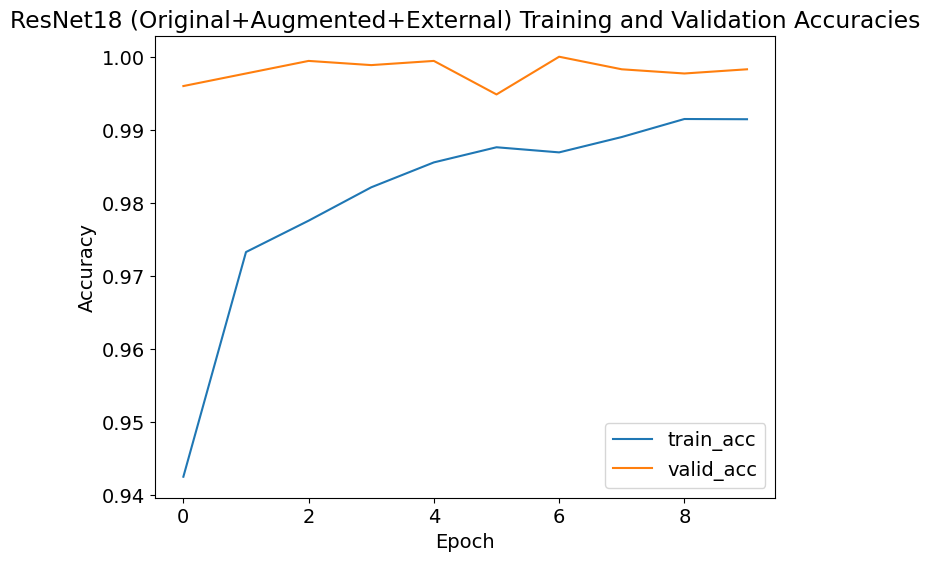

In [ ]:
# Train original + augmented + external and save
model_resnet18_d = get_pretrained_model('resnet18')
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_resnet18_d.parameters())

model_resnet18_d, history_resnet18_d = train(
    model_resnet18_d,
    criterion,
    optimizer,
    train_loader_d,
    valid_loader_d,
    n_epochs=15)

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(history_resnet18_d[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet18 (Original+Augmented+External) Training and Validation Accuracies')

torch.save(model_resnet18_d.state_dict(), save_location+'resnet18_original_plus_augmented_plus_external_data.pth')

## Test Model and Get Evaluation Metrics

In [ ]:
# Get metrics by running on test set
accuracy_o, runtime_o, peak_mem_o, test_outputs_o, y_pred_o, f1_o = get_metrics(x_test_o, y_test_o, model_resnet18_o)
accuracy_a, runtime_a, peak_mem_a, test_outputs_a, y_pred_a, f1_a = get_metrics(x_test_a, y_test_a, model_resnet18_a)
accuracy_d, runtime_d, peak_mem_d, test_outputs_d, y_pred_d, f1_d = get_metrics(x_test_d, y_test_d, model_resnet18_d)

In [ ]:
results = {
    "Data": ["Original", "Augmented", "Augmented + External"],
    "Accuracy": [accuracy_o, accuracy_a, accuracy_d],
    "Runtime (1 img)": [runtime_o / test_outputs_o[0].size(0), runtime_a / test_outputs_a[0].size(0), runtime_d / test_outputs_d[0].size(0)],
    "Peak Memory (1 img)": [peak_mem_o / test_outputs_o[0].size(0), peak_mem_a / test_outputs_a[0].size(0), peak_mem_d / test_outputs_d[0].size(0)],
    "Average F1 Score": [f1_o, f1_a, f1_d]
}

results_pd = pd.DataFrame(results)
results_pd

,Data,Accuracy,Runtime (1 img),Peak Memory (1 img),Average F1 Score
0,Original,0.987903,0.108186,2040.455078,0.987901
1,Augmented,0.963710,0.106513,2040.482422,0.963684
2,Augmented + External,0.954839,0.105953,2040.482422,0.954746


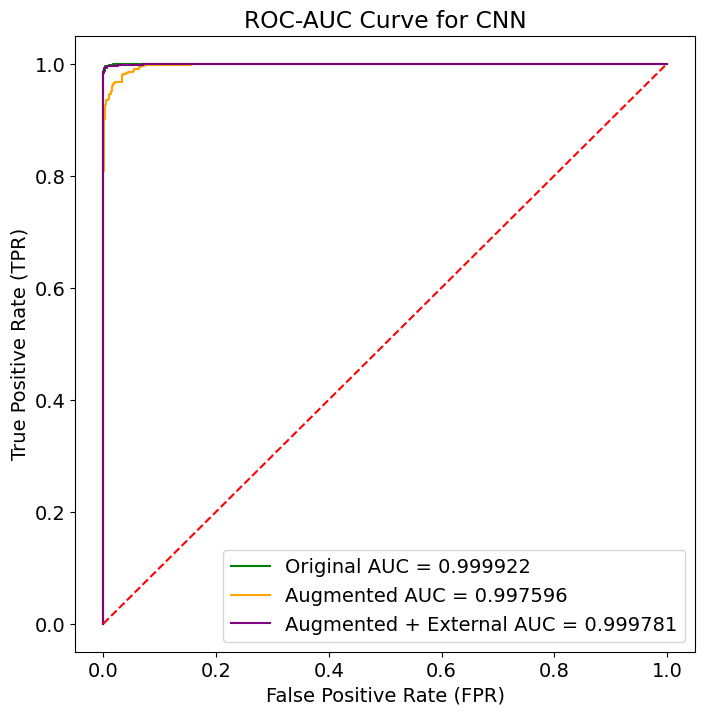

In [ ]:
# Plot ROC-AUC Curve

# get liver probabilities from the test outputs
y_probs_o = torch.nn.functional.softmax(test_outputs_o.cpu(), dim=1).detach().numpy()[:, 1]
y_probs_a = torch.nn.functional.softmax(test_outputs_a.cpu(), dim=1).detach().numpy()[:, 1]
y_probs_d = torch.nn.functional.softmax(test_outputs_d.cpu(), dim=1).detach().numpy()[:, 1]

# plot the curves
y_data = [(y_test_o.cpu().numpy(), y_probs_o, 'green', 'Original'), (y_test_a.cpu().numpy(), y_probs_a, 'orange', 'Augmented'), (y_test_d.cpu().numpy(), y_probs_d, 'purple', 'Augmented + External')]
auc_roc_curves(y_data, "CNN")

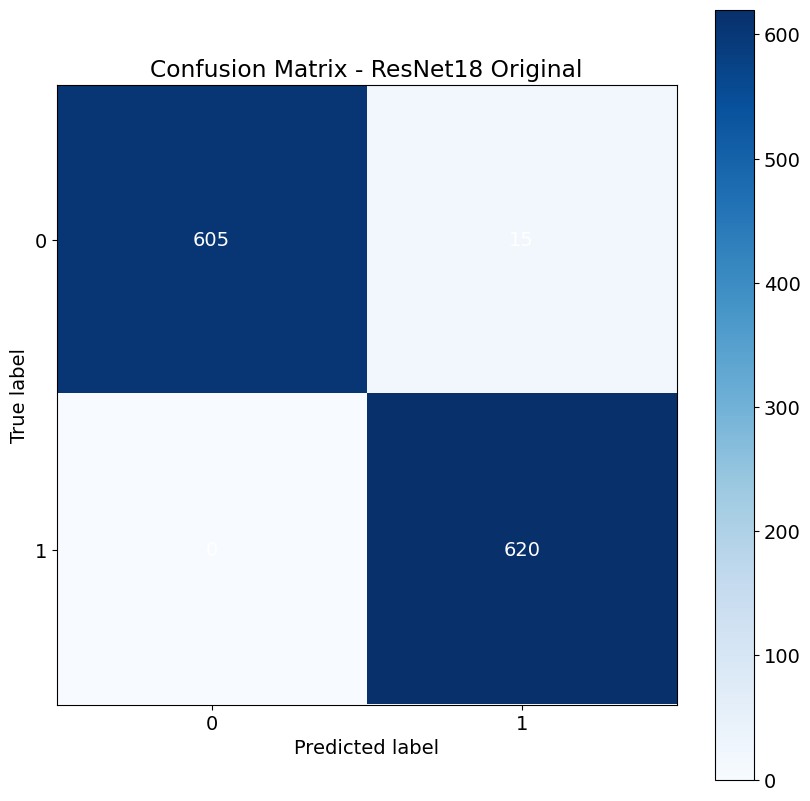

In [ ]:
# Original
create_confusion_matrix(y_test_o.cpu().numpy(), y_pred_o, title="- ResNet18 Original")

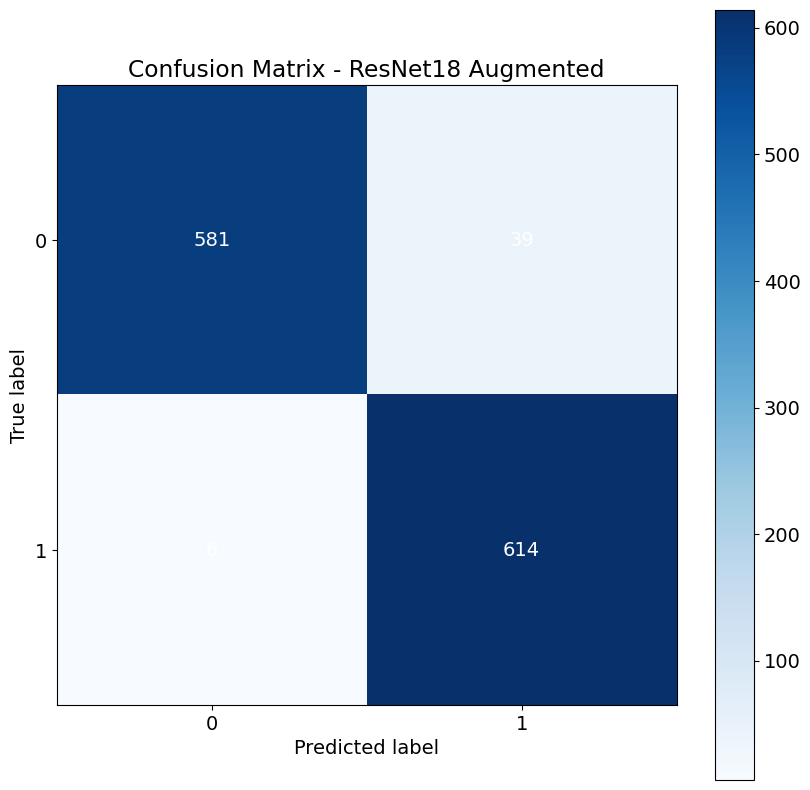

In [ ]:
# Original + Augmented Confusion Matrix
create_confusion_matrix(y_test_a.cpu().numpy(), y_pred_a, title="- ResNet18 Augmented")

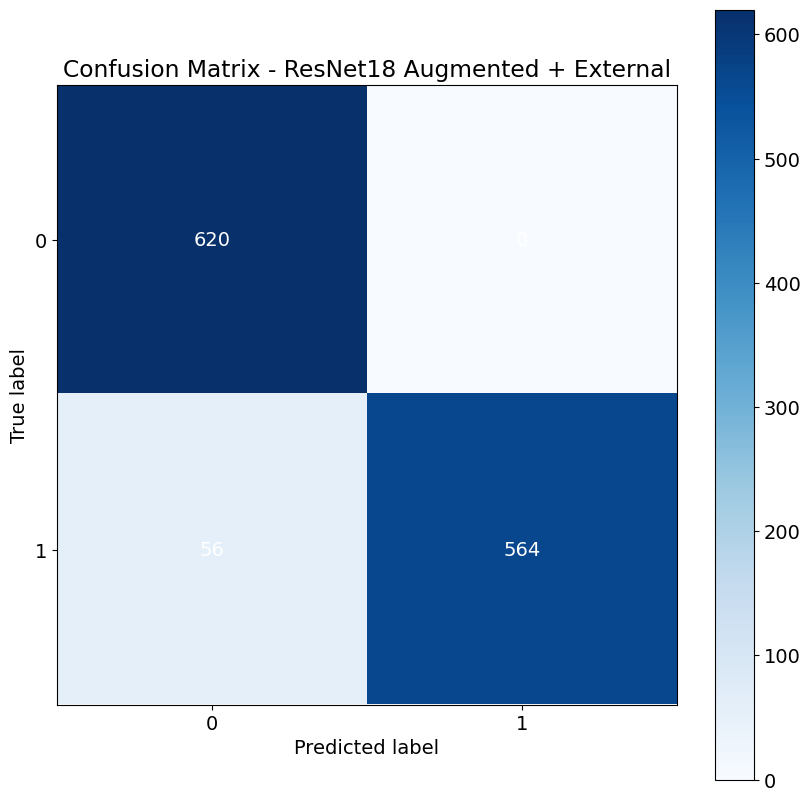

In [ ]:
# Original + Augmented + External Confusion Matrix
create_confusion_matrix(y_test_d.cpu().numpy(), y_pred_d, title="- ResNet18 Augmented + External")

# GoogLeNet

In [ ]:
batch_size = 64

## Original Data

In [ ]:
# initialize model
model_googlenet_o = get_pretrained_model('googlenet')
input_size = (1, 1024, 768)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_googlenet_o.parameters())

if multi_gpu:
    summary(
        model_googlenet_o.module,
        input_size=input_size,
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model_googlenet_o,
        input_size=input_size,
        batch_size=batch_size,
        device='cuda')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 93.1MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 512, 384]           3,136
       BatchNorm2d-2         [64, 64, 512, 384]             128
       BasicConv2d-3         [64, 64, 512, 384]               0
         MaxPool2d-4         [64, 64, 256, 192]               0
            Conv2d-5         [64, 64, 256, 192]           4,096
       BatchNorm2d-6         [64, 64, 256, 192]             128
       BasicConv2d-7         [64, 64, 256, 192]               0
            Conv2d-8        [64, 192, 256, 192]         110,592
       BatchNorm2d-9        [64, 192, 256, 192]             384
      BasicConv2d-10        [64, 192, 256, 192]               0
        MaxPool2d-11         [64, 192, 128, 96]               0
           Conv2d-12          [64, 64, 128, 96]          12,288
      BatchNorm2d-13          [64, 64, 128, 96]             128
      BasicConv2d-14          [64, 64, 


Epoch: 1 	Training Loss: 0.2288 	Validation Loss: 0.0824
		Training Accuracy: 89.95%	 Validation Accuracy: 97.48%

Epoch: 2 	Training Loss: 0.1090 	Validation Loss: 0.0968
		Training Accuracy: 95.89%	 Validation Accuracy: 96.33%

Epoch: 3 	Training Loss: 0.1039 	Validation Loss: 0.2060
		Training Accuracy: 96.12%	 Validation Accuracy: 90.42%

Epoch: 4 	Training Loss: 0.0811 	Validation Loss: 0.0237
		Training Accuracy: 96.99%	 Validation Accuracy: 99.37%

Epoch: 5 	Training Loss: 0.0685 	Validation Loss: 0.0955
		Training Accuracy: 97.65%	 Validation Accuracy: 96.90%

Epoch: 6 	Training Loss: 0.0556 	Validation Loss: 0.0454
		Training Accuracy: 98.02%	 Validation Accuracy: 98.34%

Epoch: 7 	Training Loss: 0.0612 	Validation Loss: 0.0135
		Training Accuracy: 97.72%	 Validation Accuracy: 99.48%

Epoch: 8 	Training Loss: 0.0500 	Validation Loss: 0.0857
		Training Accuracy: 97.95%	 Validation Accuracy: 97.65%

Epoch: 9 	Training Loss: 0.0477 	Validation Loss: 0.0300
		Training Accuracy: 9

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'GoogLeNet (Original) Training and Validation Accuracies')

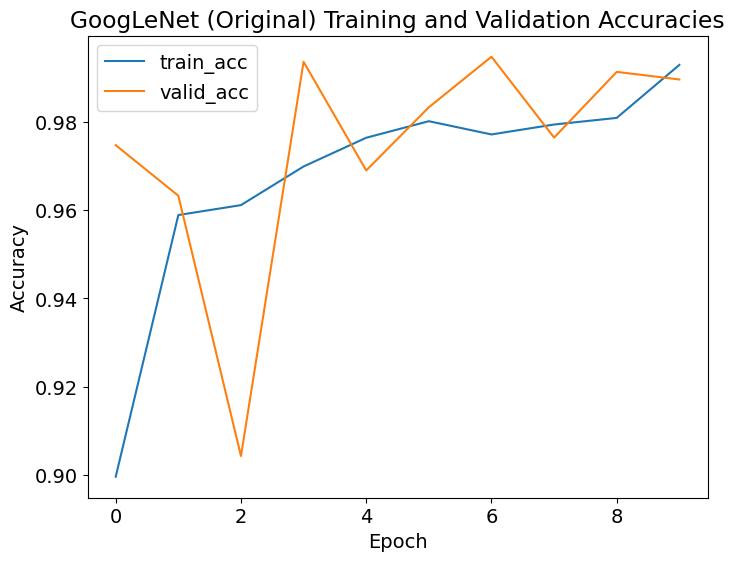

In [ ]:
# Train original and save

model_googlenet_o, history_googlenet_o = train(
    model_googlenet_o,
    criterion,
    optimizer,
    train_loader_o,
    valid_loader_o,
    n_epochs=15)

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(history_googlenet_o[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GoogLeNet (Original) Training and Validation Accuracies')

torch.save(model_googlenet_o.state_dict(), save_location+'googlenet_original_data.pth')

## Original + Augmented

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 1 	Training Loss: 0.2150 	Validation Loss: 0.0301
		Training Accuracy: 90.95%	 Validation Accuracy: 99.14%

Epoch: 2 	Training Loss: 0.1322 	Validation Loss: 0.0388
		Training Accuracy: 94.88%	 Validation Accuracy: 98.80%

Epoch: 3 	Training Loss: 0.1009 	Validation Loss: 0.0227
		Training Accuracy: 96.18%	 Validation Accuracy: 99.03%

Epoch: 4 	Training Loss: 0.0810 	Validation Loss: 0.0077
		Training Accuracy: 96.92%	 Validation Accuracy: 99.83%

Epoch: 5 	Training Loss: 0.0669 	Validation Loss: 0.0126
		Training Accuracy: 97.45%	 Validation Accuracy: 99.48%

Epoch: 6 	Training Loss: 0.0602 	Validation Loss: 0.0159
		Training Accuracy: 97.65%	 Validation Accuracy: 99.71%

Epoch: 7 	Training Loss: 0.0560 	Validation Loss: 0.0059
		Training Accuracy: 97.91%	 Validation Accuracy: 99.77%

Epoch: 8 	Training Loss: 0.0536 	Validation Loss: 0.0038
		Training Accuracy: 98.14%	 Validation Accuracy: 99.94%

Epoch: 9 	Training Loss: 0.0489 	Validation Loss: 0.0110
		Training Accuracy: 9

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'GoogLeNet (Original + Augmented Data) Training and Validation Accuracies')

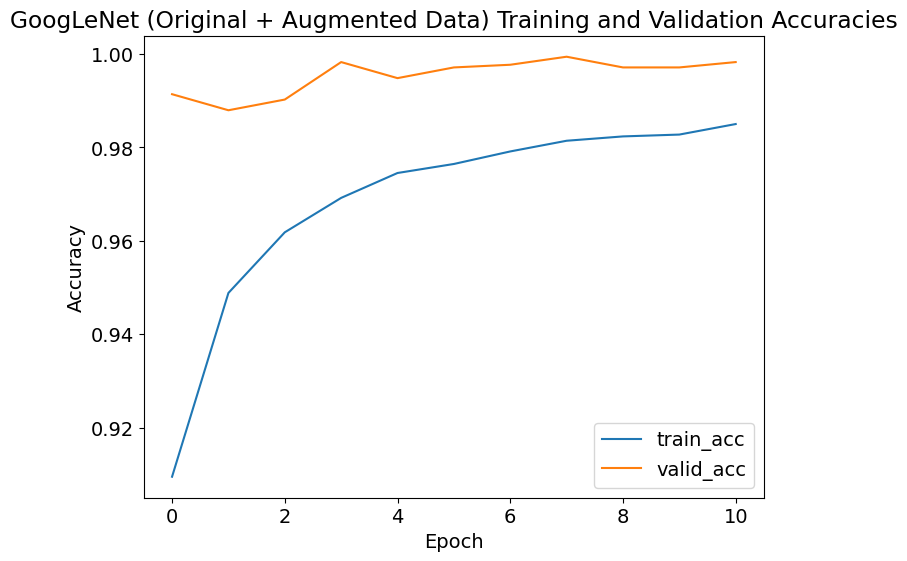

In [ ]:
# Train original + augmented and save
model_googlenet_a = get_pretrained_model('googlenet')
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_googlenet_a.parameters())

model_googlenet_a, history_googlenet_a = train(
    model_googlenet_a,
    criterion,
    optimizer,
    train_loader_a,
    valid_loader_a,
    n_epochs=15)

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(history_googlenet_a[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GoogLeNet (Original + Augmented Data) Training and Validation Accuracies')

torch.save(model_googlenet_a.state_dict(), save_location+'googlenet_original_plus_augmented_data.pth')

## Original + Augmented + External

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 1 	Training Loss: 0.2041 	Validation Loss: 0.1327
		Training Accuracy: 91.27%	 Validation Accuracy: 95.99%

Epoch: 2 	Training Loss: 0.1143 	Validation Loss: 0.0302
		Training Accuracy: 95.40%	 Validation Accuracy: 99.20%

Epoch: 3 	Training Loss: 0.1012 	Validation Loss: 0.0292
		Training Accuracy: 96.00%	 Validation Accuracy: 99.20%

Epoch: 4 	Training Loss: 0.0770 	Validation Loss: 0.0170
		Training Accuracy: 97.05%	 Validation Accuracy: 99.37%

Epoch: 5 	Training Loss: 0.0639 	Validation Loss: 0.0247
		Training Accuracy: 97.57%	 Validation Accuracy: 99.31%

Epoch: 6 	Training Loss: 0.0596 	Validation Loss: 0.0149
		Training Accuracy: 97.80%	 Validation Accuracy: 99.54%

Epoch: 7 	Training Loss: 0.0574 	Validation Loss: 0.0119
		Training Accuracy: 97.87%	 Validation Accuracy: 99.54%

Epoch: 8 	Training Loss: 0.0527 	Validation Loss: 0.0351
		Training Accuracy: 98.08%	 Validation Accuracy: 99.31%

Epoch: 9 	Training Loss: 0.0496 	Validation Loss: 0.0179
		Training Accuracy: 9

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'GoogLeNet (Original+Augmented+External) Training and Validation Accuracies')

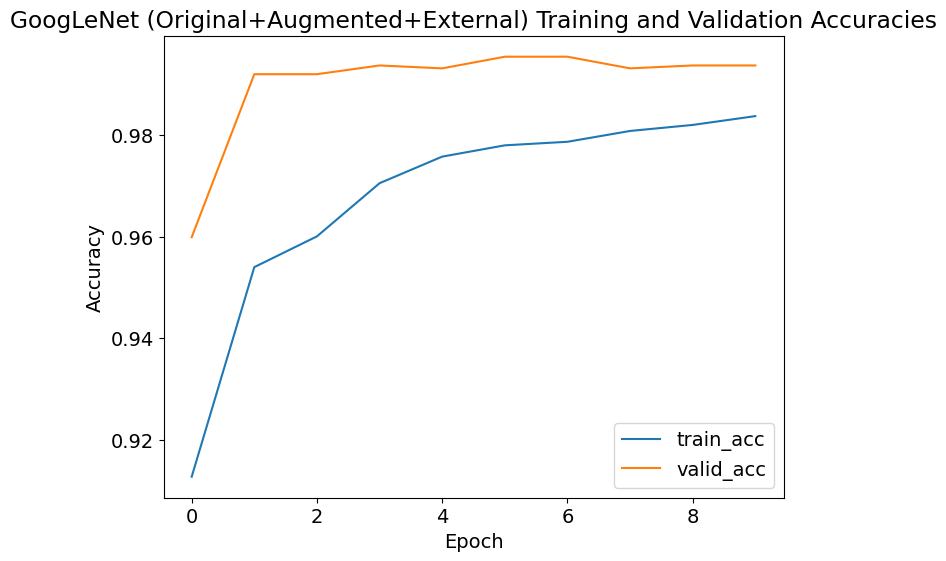

In [ ]:
# Train original + augmented + external and save
model_googlenet_d = get_pretrained_model('googlenet')
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_googlenet_d.parameters())

model_googlenet_d, history_googlenet_d = train(
    model_googlenet_d,
    criterion,
    optimizer,
    train_loader_d,
    valid_loader_d,
    n_epochs=15)

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(history_googlenet_d[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GoogLeNet (Original+Augmented+External) Training and Validation Accuracies')

torch.save(model_googlenet_d.state_dict(), save_location+'googlenet_original_plus_augmented_plus_external_data.pth')

## Test Model and Get Evaluation Metrics

In [ ]:
accuracy_o, runtime_o, peak_mem_o, test_outputs_o, y_pred_o, f1_o = get_metrics(x_test_o, y_test_o, model_googlenet_o)
accuracy_a, runtime_a, peak_mem_a, test_outputs_a, y_pred_a, f1_a = get_metrics(x_test_a, y_test_a, model_googlenet_a)
accuracy_d, runtime_d, peak_mem_d, test_outputs_d, y_pred_d, f1_d = get_metrics(x_test_d, y_test_d, model_googlenet_d)

In [ ]:
results = {
    "Data": ["Original", "Augmented", "Augmented + External"],
    "Accuracy": [accuracy_o, accuracy_a, accuracy_d],
    "Runtime (1 img)": [runtime_o / test_outputs_o[0].size(0), runtime_a / test_outputs_a[0].size(0), runtime_d / test_outputs_d[0].size(0)],
    "Peak Memory (1 img)": [peak_mem_o / test_outputs_o[0].size(0), peak_mem_a / test_outputs_a[0].size(0), peak_mem_d / test_outputs_d[0].size(0)],
    "Average F1 Score": [f1_o, f1_a, f1_d]
}

results_pd = pd.DataFrame(results)
results_pd

,Data,Accuracy,Runtime (1 img),Peak Memory (1 img),Average F1 Score
0,Original,0.966129,0.255433,1980.916016,0.966097
1,Augmented,0.970161,0.114719,1981.009766,0.970135
2,Augmented + External,0.988710,0.115053,1981.009766,0.988708


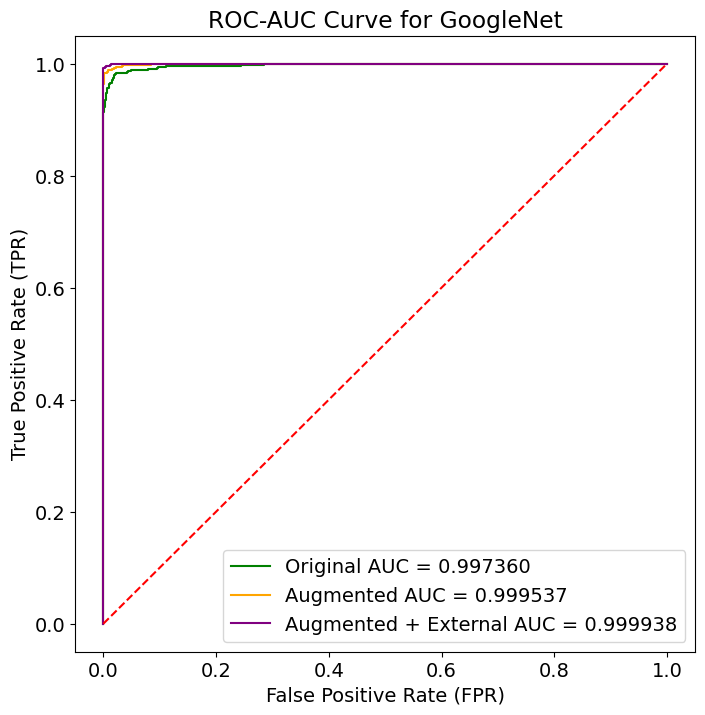

In [ ]:
# Plot ROC-AUC Curve

# get liver probabilities from the test outputs
y_probs_o = torch.nn.functional.softmax(test_outputs_o.cpu(), dim=1).detach().numpy()[:, 1]
y_probs_a = torch.nn.functional.softmax(test_outputs_a.cpu(), dim=1).detach().numpy()[:, 1]
y_probs_d = torch.nn.functional.softmax(test_outputs_d.cpu(), dim=1).detach().numpy()[:, 1]

# plot the curves
y_data = [(y_test_o.cpu().numpy(), y_probs_o, 'green', 'Original'), (y_test_a.cpu().numpy(), y_probs_a, 'orange', 'Augmented'), (y_test_d.cpu().numpy(), y_probs_d, 'purple', 'Augmented + External')]
auc_roc_curves(y_data, "GoogleNet")

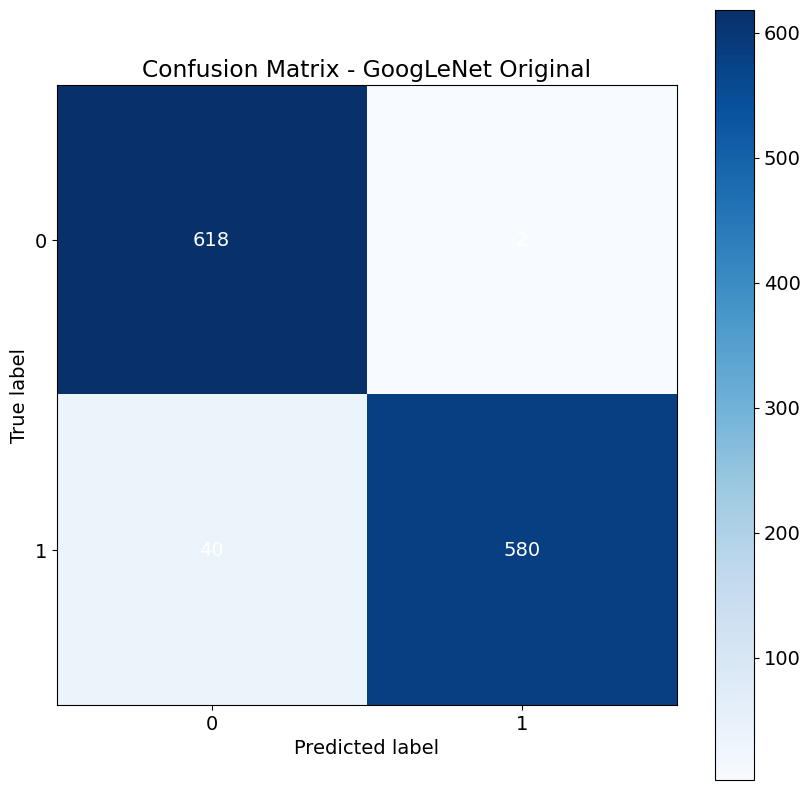

In [ ]:
# Original
create_confusion_matrix(y_test_o.cpu().numpy(), y_pred_o, title="- GoogLeNet Original")

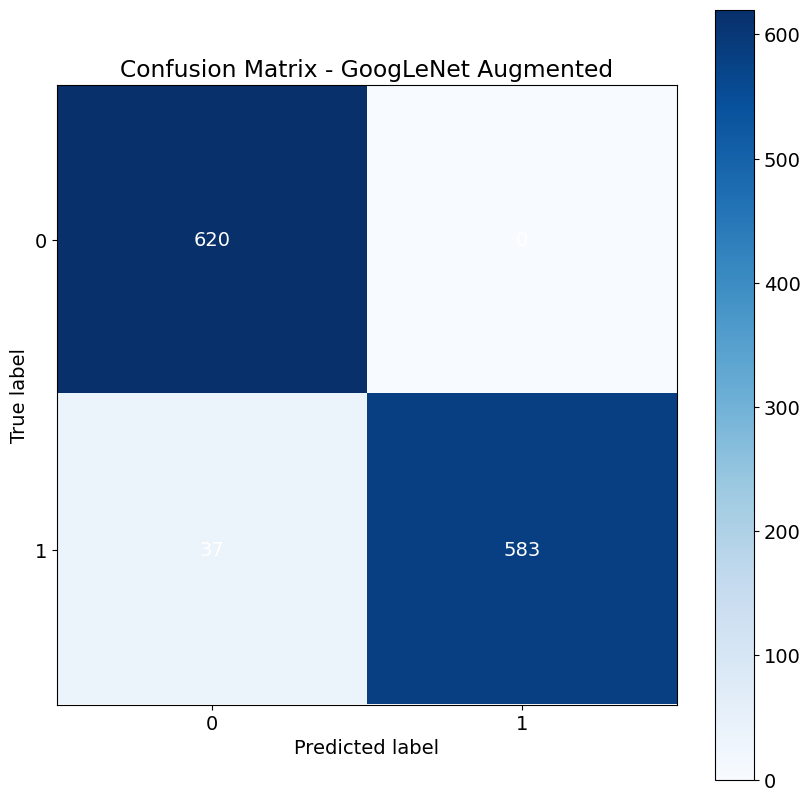

In [ ]:
# Original + Augmented Confusion Matrix
create_confusion_matrix(y_test_a.cpu().numpy(), y_pred_a, title="- GoogLeNet Augmented")

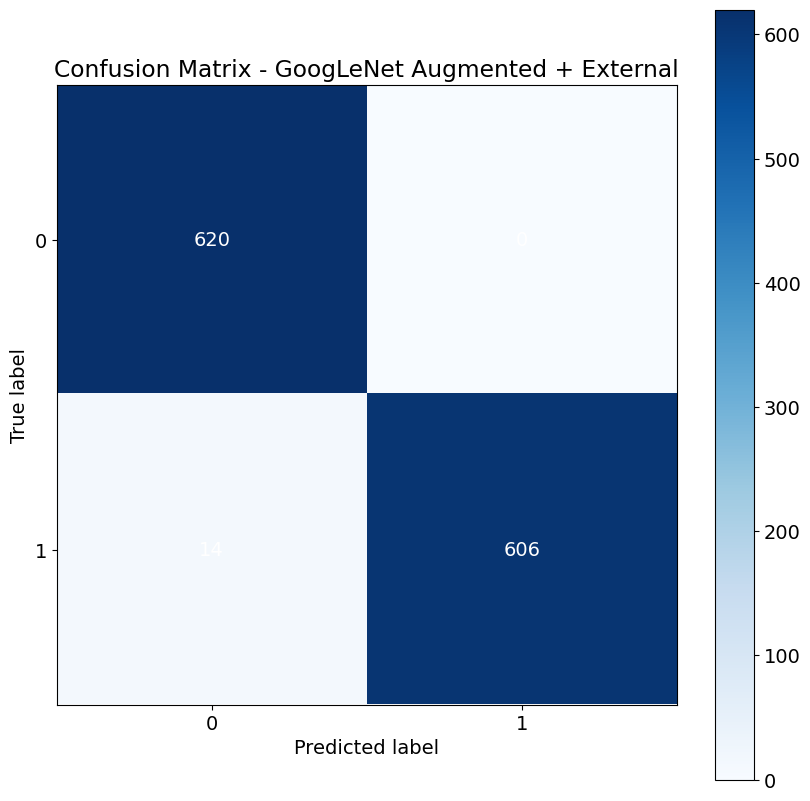

In [ ]:
# Original + Augmented + External Confusion Matrix
create_confusion_matrix(y_test_d.cpu().numpy(), y_pred_d, title="- GoogLeNet Augmented + External")

# AlexNet

In [ ]:
batch_size = 64

## Original Data

In [ ]:
# initialize model
model_alexnet_o = get_pretrained_model('alexnet')
input_size = (1, 1024, 768)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_alexnet_o.parameters())

if multi_gpu:
    summary(
        model_alexnet_o.module,
        input_size=input_size,
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model_alexnet_o,
        input_size=input_size,
        batch_size=batch_size,
        device='cuda')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 512, 384]           3,136
              ReLU-2         [64, 64, 512, 384]               0
         MaxPool2d-3         [64, 64, 255, 191]               0
            Conv2d-4        [64, 192, 255, 191]         307,392
              ReLU-5        [64, 192, 255, 191]               0
         MaxPool2d-6         [64, 192, 127, 95]               0
            Conv2d-7         [64, 384, 127, 95]         663,936
              ReLU-8         [64, 384, 127, 95]               0
            Conv2d-9         [64, 256, 127, 95]         884,992
             ReLU-10         [64, 256, 127, 95]               0
           Conv2d-11         [64, 256, 127, 95]         590,080
             ReLU-12         [64, 256, 127, 95]               0
        MaxPool2d-13          [64, 256, 63, 47]               0
AdaptiveAvgPool2d-14            [64, 25


Epoch: 1 	Training Loss: 0.3700 	Validation Loss: 0.0373
		Training Accuracy: 83.62%	 Validation Accuracy: 99.31%

Epoch: 2 	Training Loss: 0.1441 	Validation Loss: 0.0294
		Training Accuracy: 94.49%	 Validation Accuracy: 99.14%

Epoch: 3 	Training Loss: 0.1425 	Validation Loss: 0.0418
		Training Accuracy: 94.46%	 Validation Accuracy: 98.97%

Epoch: 4 	Training Loss: 0.1153 	Validation Loss: 0.0357
		Training Accuracy: 95.62%	 Validation Accuracy: 99.31%

Epoch: 5 	Training Loss: 0.0969 	Validation Loss: 0.0204
		Training Accuracy: 96.14%	 Validation Accuracy: 99.43%

Epoch: 6 	Training Loss: 0.0656 	Validation Loss: 0.0184
		Training Accuracy: 97.39%	 Validation Accuracy: 99.60%

Epoch: 7 	Training Loss: 0.0542 	Validation Loss: 0.0239
		Training Accuracy: 97.97%	 Validation Accuracy: 99.48%

Epoch: 8 	Training Loss: 0.0850 	Validation Loss: 0.0237
		Training Accuracy: 96.59%	 Validation Accuracy: 99.37%

Epoch: 9 	Training Loss: 0.0508 	Validation Loss: 0.0201
		Training Accuracy: 9

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'AlexNet (Original) Training and Validation Accuracies')

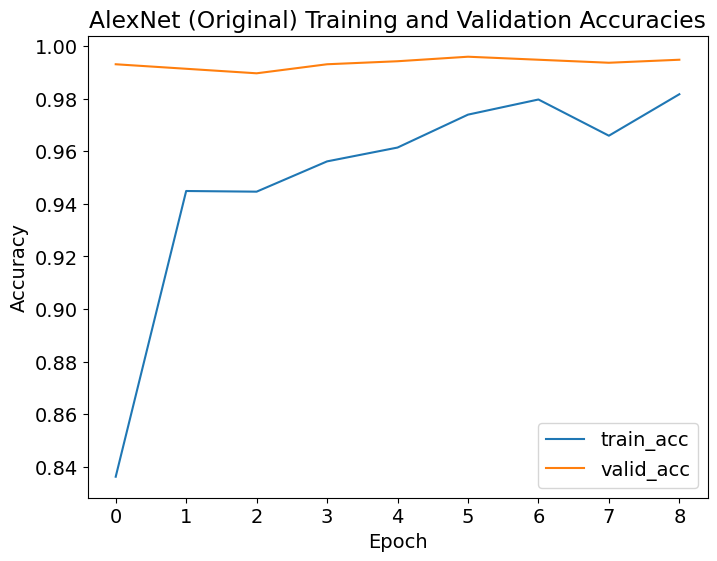

In [ ]:
# Train original and save

model_alexnet_o, history_alexnet_o = train(
    model_alexnet_o,
    criterion,
    optimizer,
    train_loader_o,
    valid_loader_o,
    n_epochs=15)

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(history_alexnet_o[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('AlexNet (Original) Training and Validation Accuracies')

torch.save(model_alexnet_o.state_dict(), save_location+'alexnet_original_data.pth')

## Original + Augmented

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 1 	Training Loss: 0.2347 	Validation Loss: 0.0296
		Training Accuracy: 89.98%	 Validation Accuracy: 99.31%

Epoch: 2 	Training Loss: 0.1107 	Validation Loss: 0.0155
		Training Accuracy: 95.84%	 Validation Accuracy: 99.37%

Epoch: 3 	Training Loss: 0.0866 	Validation Loss: 0.0071
		Training Accuracy: 96.83%	 Validation Accuracy: 99.89%

Epoch: 4 	Training Loss: 0.0740 	Validation Loss: 0.0137
		Training Accuracy: 97.21%	 Validation Accuracy: 99.71%

Epoch: 5 	Training Loss: 0.0676 	Validation Loss: 0.0206
		Training Accuracy: 97.53%	 Validation Accuracy: 99.48%

Epoch: 6 	Training Loss: 0.0607 	Validation Loss: 0.0167
		Training Accuracy: 97.80%	 Validation Accuracy: 99.54%

Early Stopping

Total epochs: 7. Best epoch: 3 with loss: 0.0071 and acc: 99.54%
100.99 total seconds elapsed. 14.43 seconds per epoch.


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'AlexNet (Original + Augmented Data) Training and Validation Accuracies')

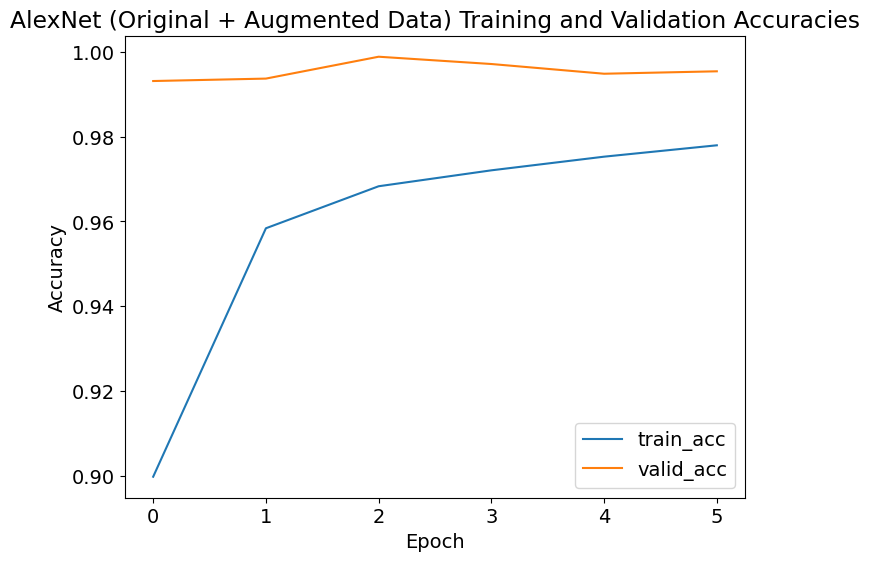

In [ ]:
# Train original + augmented and save
model_alexnet_a = get_pretrained_model('alexnet')
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_alexnet_a.parameters())

model_alexnet_a, history_alexnet_a = train(
    model_alexnet_a,
    criterion,
    optimizer,
    train_loader_a,
    valid_loader_a,
    n_epochs=15)

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(history_alexnet_a[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('AlexNet (Original + Augmented Data) Training and Validation Accuracies')

torch.save(model_alexnet_a.state_dict(), save_location+'alexnet_original_plus_augmented_data.pth')

## Original + Augmented + External

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 1 	Training Loss: 0.2620 	Validation Loss: 0.0617
		Training Accuracy: 89.29%	 Validation Accuracy: 98.51%

Epoch: 2 	Training Loss: 0.1450 	Validation Loss: 0.0281
		Training Accuracy: 94.37%	 Validation Accuracy: 99.37%

Epoch: 3 	Training Loss: 0.1202 	Validation Loss: 0.0309
		Training Accuracy: 95.46%	 Validation Accuracy: 99.31%

Epoch: 4 	Training Loss: 0.1049 	Validation Loss: 0.0260
		Training Accuracy: 96.05%	 Validation Accuracy: 99.37%

Epoch: 5 	Training Loss: 0.0992 	Validation Loss: 0.0288
		Training Accuracy: 96.17%	 Validation Accuracy: 99.54%

Epoch: 6 	Training Loss: 0.0954 	Validation Loss: 0.0146
		Training Accuracy: 96.42%	 Validation Accuracy: 99.48%

Epoch: 7 	Training Loss: 0.0892 	Validation Loss: 0.0291
		Training Accuracy: 96.72%	 Validation Accuracy: 99.20%

Epoch: 8 	Training Loss: 0.0837 	Validation Loss: 0.0287
		Training Accuracy: 96.91%	 Validation Accuracy: 99.48%

Epoch: 9 	Training Loss: 0.0806 	Validation Loss: 0.0109
		Training Accuracy: 9

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'AlexNet (Original+Augmented+External) Training and Validation Accuracies')

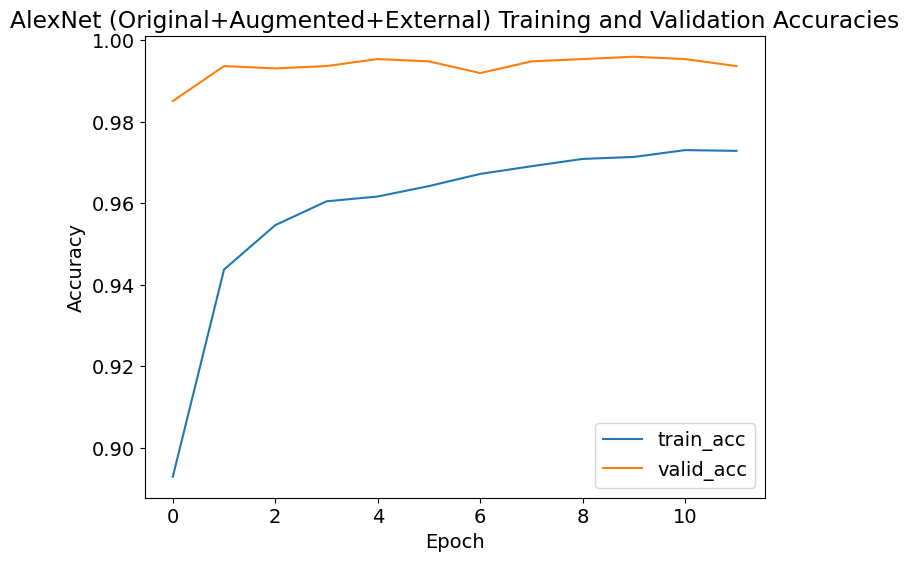

In [ ]:
# Train original + augmented + external and save
model_alexnet_d = get_pretrained_model('alexnet')
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_alexnet_d.parameters())

model_alexnet_d, history_alexnet_d = train(
    model_alexnet_d,
    criterion,
    optimizer,
    train_loader_d,
    valid_loader_d,
    n_epochs=15)

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(history_alexnet_d[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('AlexNet (Original+Augmented+External) Training and Validation Accuracies')

torch.save(model_alexnet_d.state_dict(), save_location+'alexnet_original_plus_augmented_plus_external_data.pth')

## Test Model and Get Evaluation Metrics

In [ ]:
accuracy_o, runtime_o, peak_mem_o, test_outputs_o, y_pred_o, f1_o = get_metrics(x_test_o, y_test_o, model_alexnet_o)
accuracy_a, runtime_a, peak_mem_a, test_outputs_a, y_pred_a, f1_a = get_metrics(x_test_a, y_test_a, model_alexnet_a)
accuracy_d, runtime_d, peak_mem_d, test_outputs_d, y_pred_d, f1_d = get_metrics(x_test_d, y_test_d, model_alexnet_d)

In [ ]:
results = {
    "Data": ["Original", "Augmented", "Augmented + External"],
    "Accuracy": [accuracy_o, accuracy_a, accuracy_d],
    "Runtime (1 img)": [runtime_o / test_outputs_o[0].size(0), runtime_a / test_outputs_a[0].size(0), runtime_d / test_outputs_d[0].size(0)],
    "Peak Memory (1 img)": [peak_mem_o / test_outputs_o[0].size(0), peak_mem_a / test_outputs_a[0].size(0), peak_mem_d / test_outputs_d[0].size(0)],
    "Average F1 Score": [f1_o, f1_a, f1_d]
}

results_pd = pd.DataFrame(results)
results_pd

,Data,Accuracy,Runtime (1 img),Peak Memory (1 img),Average F1 Score
0,Original,1.000000,0.520585,1869.517578,1.000000
1,Augmented,1.000000,0.144572,1869.529297,1.000000
2,Augmented + External,0.995968,0.102141,1869.529297,0.995968


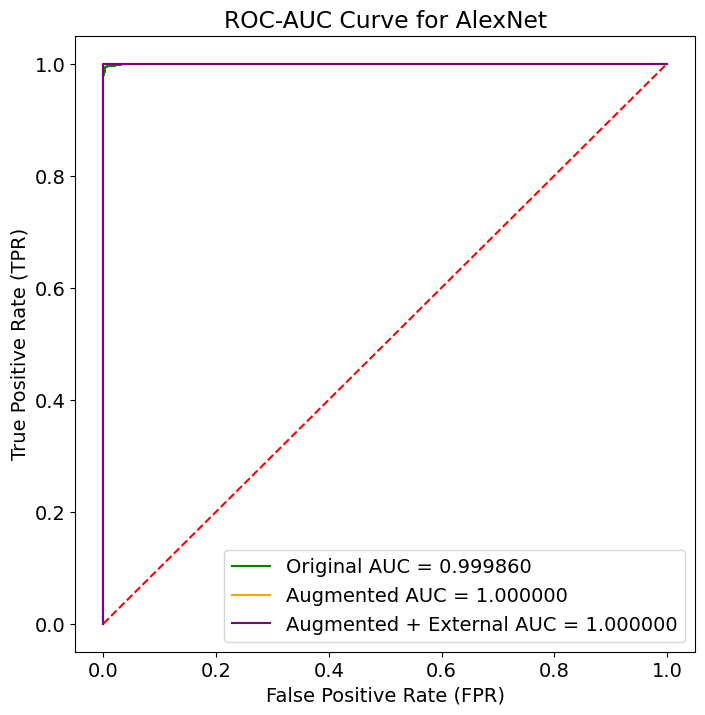

In [ ]:
# Plot ROC-AUC Curve

# get liver probabilities from the test outputs
y_probs_o = torch.nn.functional.softmax(test_outputs_o.cpu(), dim=1).detach().numpy()[:, 1]
y_probs_a = torch.nn.functional.softmax(test_outputs_a.cpu(), dim=1).detach().numpy()[:, 1]
y_probs_d = torch.nn.functional.softmax(test_outputs_d.cpu(), dim=1).detach().numpy()[:, 1]

# plot the curves
y_data = [(y_test_o.cpu().numpy(), y_probs_o, 'green', 'Original'), (y_test_a.cpu().numpy(), y_probs_a, 'orange', 'Augmented'), (y_test_d.cpu().numpy(), y_probs_d, 'purple', 'Augmented + External')]
auc_roc_curves(y_data, "AlexNet")

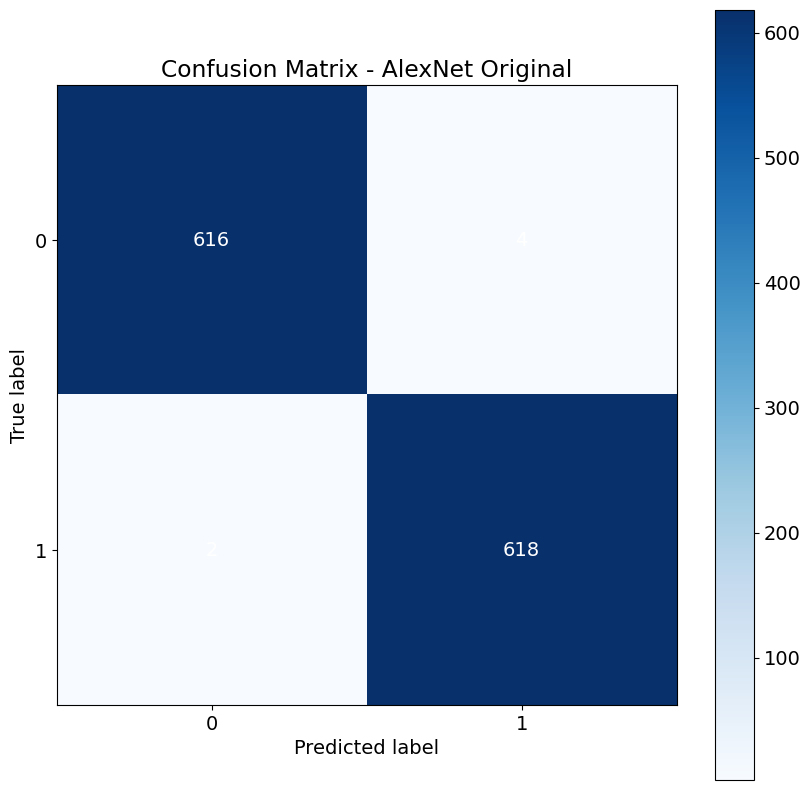

In [ ]:
# Original
create_confusion_matrix(y_test_o.cpu().numpy(), y_pred_o, title="- AlexNet Original")

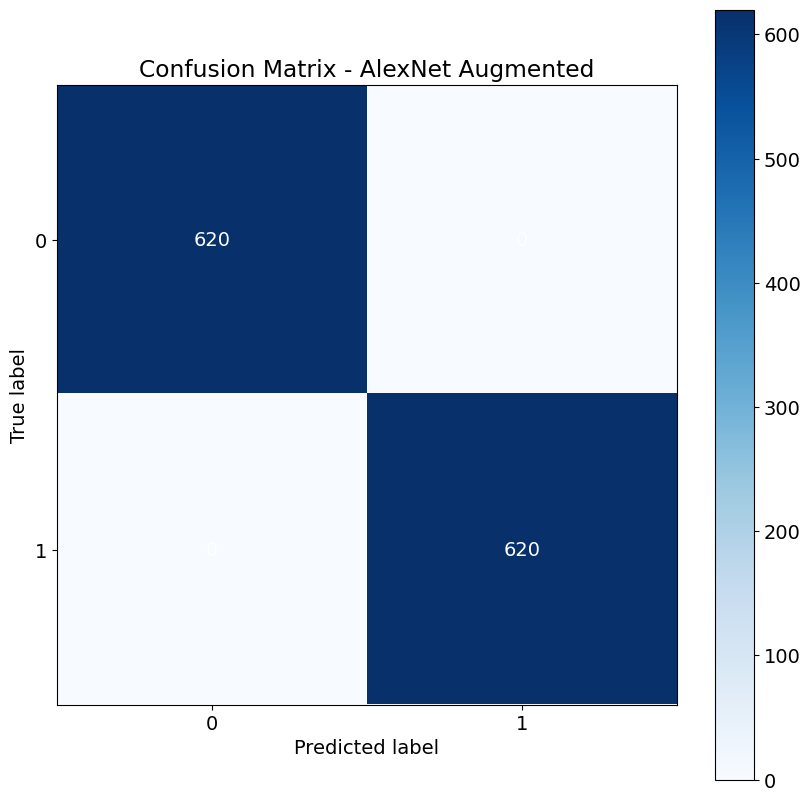

In [ ]:
# Original + Augmented Confusion Matrix
create_confusion_matrix(y_test_a.cpu().numpy(), y_pred_a, title="- AlexNet Augmented")

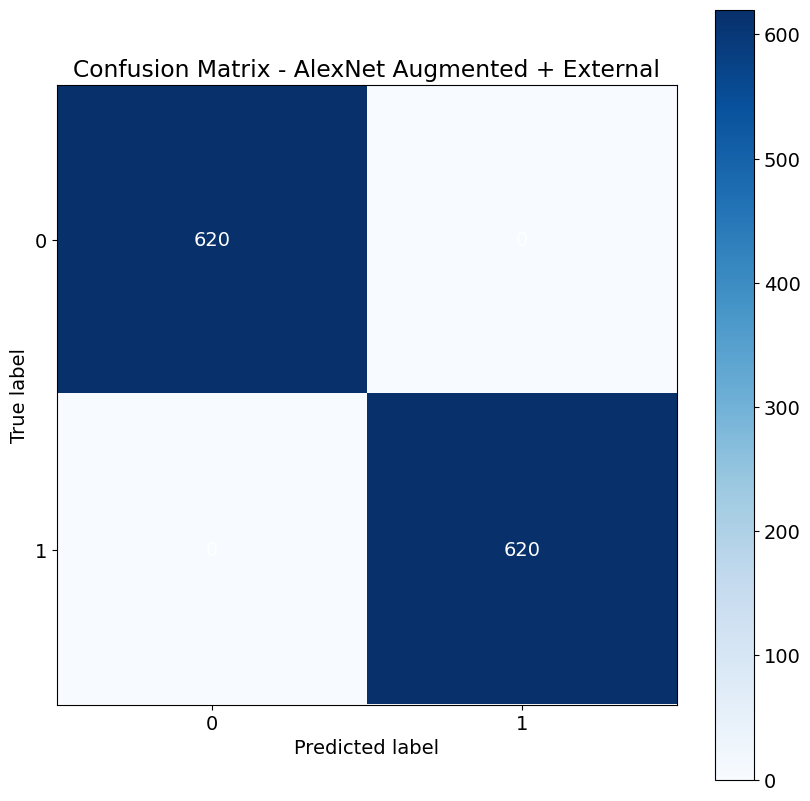

In [ ]:
# Original + Augmented + External Confusion Matrix
create_confusion_matrix(y_test_d.cpu().numpy(), y_pred_d, title="- AlexNet Augmented + External")

# VGGNet-16

In [ ]:
batch_size = 64

## Original Data

In [ ]:
# initialize model
model_vggnet_o = get_pretrained_model('vgg16')
input_size = (1, 1024, 768)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_vggnet_o.parameters())

if multi_gpu:
    summary(
        model_vggnet_o.module,
        input_size=input_size,
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model_vggnet_o,
        input_size=input_size,
        batch_size=batch_size,
        device='cuda')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 58.7MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 512, 384]           3,136
              ReLU-2         [64, 64, 512, 384]               0
            Conv2d-3         [64, 64, 512, 384]          36,928
              ReLU-4         [64, 64, 512, 384]               0
         MaxPool2d-5         [64, 64, 256, 192]               0
            Conv2d-6        [64, 128, 256, 192]          73,856
              ReLU-7        [64, 128, 256, 192]               0
            Conv2d-8        [64, 128, 256, 192]         147,584
              ReLU-9        [64, 128, 256, 192]               0
        MaxPool2d-10         [64, 128, 128, 96]               0
           Conv2d-11         [64, 256, 128, 96]         295,168
             ReLU-12         [64, 256, 128, 96]               0
           Conv2d-13         [64, 256, 128, 96]         590,080
             ReLU-14         [64, 256, 


Epoch: 1 	Training Loss: 0.3229 	Validation Loss: 0.1568
		Training Accuracy: 86.42%	 Validation Accuracy: 94.27%

Epoch: 2 	Training Loss: 0.1521 	Validation Loss: 0.0793
		Training Accuracy: 94.09%	 Validation Accuracy: 97.53%

Epoch: 3 	Training Loss: 0.1107 	Validation Loss: 0.0944
		Training Accuracy: 95.59%	 Validation Accuracy: 95.81%

Epoch: 4 	Training Loss: 0.0894 	Validation Loss: 0.0422
		Training Accuracy: 96.79%	 Validation Accuracy: 98.91%

Epoch: 5 	Training Loss: 0.0750 	Validation Loss: 0.0818
		Training Accuracy: 97.12%	 Validation Accuracy: 96.67%

Epoch: 6 	Training Loss: 0.0712 	Validation Loss: 0.0313
		Training Accuracy: 97.14%	 Validation Accuracy: 99.25%

Epoch: 7 	Training Loss: 0.0641 	Validation Loss: 0.0395
		Training Accuracy: 97.65%	 Validation Accuracy: 98.91%

Epoch: 8 	Training Loss: 0.0396 	Validation Loss: 0.0420
		Training Accuracy: 98.45%	 Validation Accuracy: 98.80%

Epoch: 9 	Training Loss: 0.0627 	Validation Loss: 0.0401
		Training Accuracy: 9

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'VGGNet-16 (Original) Training and Validation Accuracies')

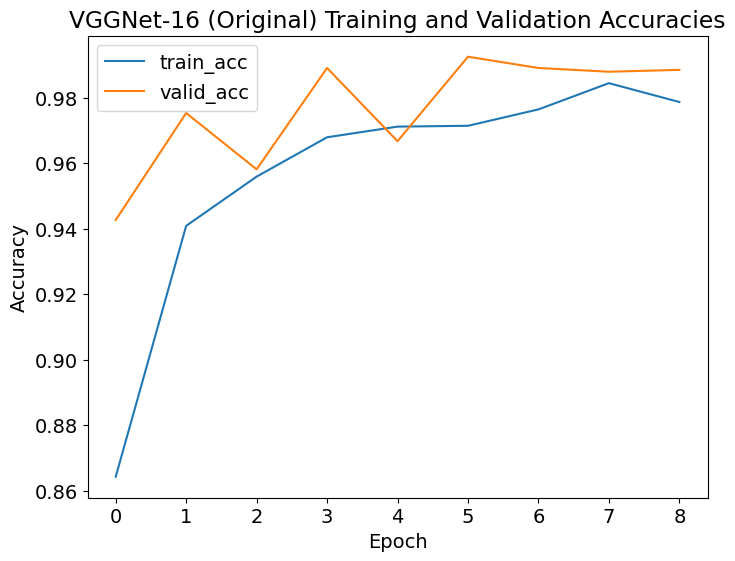

In [ ]:
# Train original and save

model_vggnet_o, history_vggnet_o = train(
    model_vggnet_o,
    criterion,
    optimizer,
    train_loader_o,
    valid_loader_o,
    n_epochs=15)

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(history_vggnet_o[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGGNet-16 (Original) Training and Validation Accuracies')

torch.save(model_vggnet_o.state_dict(), save_location+'vggnet_original_data.pth')

## Original + Augmented

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 1 	Training Loss: 0.2026 	Validation Loss: 0.0349
		Training Accuracy: 92.02%	 Validation Accuracy: 99.14%

Epoch: 2 	Training Loss: 0.1180 	Validation Loss: 0.0241
		Training Accuracy: 95.71%	 Validation Accuracy: 99.60%

Epoch: 3 	Training Loss: 0.1006 	Validation Loss: 0.0380
		Training Accuracy: 96.48%	 Validation Accuracy: 98.80%

Epoch: 4 	Training Loss: 0.0827 	Validation Loss: 0.0229
		Training Accuracy: 97.17%	 Validation Accuracy: 99.60%

Epoch: 5 	Training Loss: 0.0785 	Validation Loss: 0.0323
		Training Accuracy: 97.20%	 Validation Accuracy: 99.43%

Epoch: 6 	Training Loss: 0.0713 	Validation Loss: 0.0249
		Training Accuracy: 97.48%	 Validation Accuracy: 99.66%

Epoch: 7 	Training Loss: 0.0686 	Validation Loss: 0.0281
		Training Accuracy: 97.67%	 Validation Accuracy: 99.66%

Early Stopping

Total epochs: 8. Best epoch: 4 with loss: 0.0229 and acc: 99.66%
222.25 total seconds elapsed. 27.78 seconds per epoch.


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'VGGNet-16 (Original + Augmented Data) Training and Validation Accuracies')

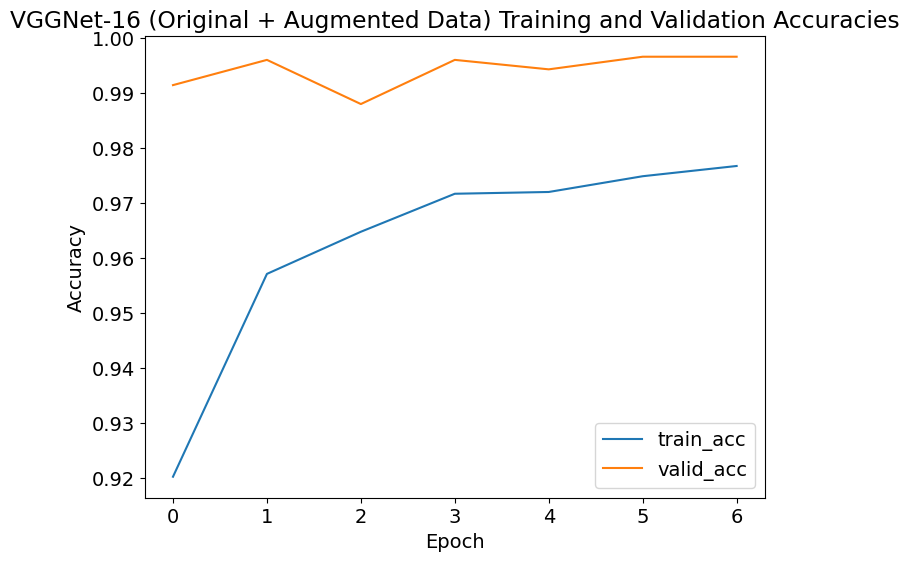

In [ ]:
# Train original + augmented and save
model_vggnet_a = get_pretrained_model('vgg16')
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_vggnet_a.parameters())

model_vggnet_a, history_vggnet_a = train(
    model_vggnet_a,
    criterion,
    optimizer,
    train_loader_a,
    valid_loader_a,
    n_epochs=15)

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(history_vggnet_a[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGGNet-16 (Original + Augmented Data) Training and Validation Accuracies')

torch.save(model_vggnet_a.state_dict(), save_location+'vggnet_original_plus_augmented_data.pth')

## Original + Augmented + External

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 1 	Training Loss: 0.2297 	Validation Loss: 0.0832
		Training Accuracy: 90.60%	 Validation Accuracy: 96.96%

Epoch: 2 	Training Loss: 0.1434 	Validation Loss: 0.0440
		Training Accuracy: 94.57%	 Validation Accuracy: 98.68%

Epoch: 3 	Training Loss: 0.1258 	Validation Loss: 0.0555
		Training Accuracy: 95.29%	 Validation Accuracy: 97.25%

Epoch: 4 	Training Loss: 0.1185 	Validation Loss: 0.0331
		Training Accuracy: 95.54%	 Validation Accuracy: 99.25%

Epoch: 5 	Training Loss: 0.1093 	Validation Loss: 0.0243
		Training Accuracy: 96.00%	 Validation Accuracy: 99.48%

Epoch: 6 	Training Loss: 0.1024 	Validation Loss: 0.0256
		Training Accuracy: 96.28%	 Validation Accuracy: 99.37%

Epoch: 7 	Training Loss: 0.0957 	Validation Loss: 0.0301
		Training Accuracy: 96.49%	 Validation Accuracy: 98.97%

Epoch: 8 	Training Loss: 0.0950 	Validation Loss: 0.0243
		Training Accuracy: 96.70%	 Validation Accuracy: 98.91%

Early Stopping

Total epochs: 9. Best epoch: 5 with loss: 0.0243 and acc: 98.91

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'VGGNet-16 (Original+Augmented+External) Training and Validation Accuracies')

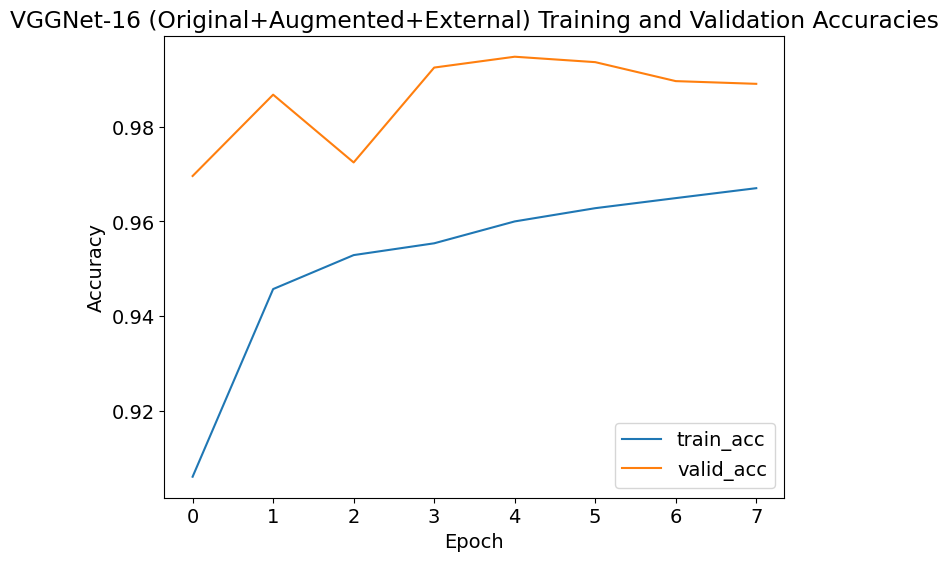

In [ ]:
# Train original + augmented + external and save
model_vggnet_d = get_pretrained_model('vgg16')
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_vggnet_d.parameters())

model_vggnet_d, history_vggnet_d = train(
    model_vggnet_d,
    criterion,
    optimizer,
    train_loader_d,
    valid_loader_d,
    n_epochs=15)

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(history_vggnet_d[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGGNet-16 (Original+Augmented+External) Training and Validation Accuracies')

torch.save(model_vggnet_d.state_dict(), save_location+'vggnet_original_plus_augmented_plus_external_data.pth')

## Test Model and Get Evaluation Metrics

In [ ]:
accuracy_o, runtime_o, peak_mem_o, test_outputs_o, y_pred_o, f1_o = get_metrics(x_test_o, y_test_o, model_vggnet_o)
accuracy_a, runtime_a, peak_mem_a, test_outputs_a, y_pred_a, f1_a = get_metrics(x_test_a, y_test_a, model_vggnet_a)
accuracy_d, runtime_d, peak_mem_d, test_outputs_d, y_pred_d, f1_d = get_metrics(x_test_d, y_test_d, model_vggnet_d)

In [ ]:
results = {
    "Data": ["Original", "Augmented", "Augmented + External"],
    "Accuracy": [accuracy_o, accuracy_a, accuracy_d],
    "Runtime (1 img)": [runtime_o / test_outputs_o[0].size(0), runtime_a / test_outputs_a[0].size(0), runtime_d / test_outputs_d[0].size(0)],
    "Peak Memory (1 img)": [peak_mem_o / test_outputs_o[0].size(0), peak_mem_a / test_outputs_a[0].size(0), peak_mem_d / test_outputs_d[0].size(0)],
    "Average F1 Score": [f1_o, f1_a, f1_d]
}

results_pd = pd.DataFrame(results)
results_pd

,Data,Accuracy,Runtime (1 img),Peak Memory (1 img),Average F1 Score
0,Original,0.987903,0.213800,1972.201172,0.987902
1,Augmented,0.992742,0.338170,1972.210938,0.992742
2,Augmented + External,0.988710,0.316157,1972.210938,0.988710


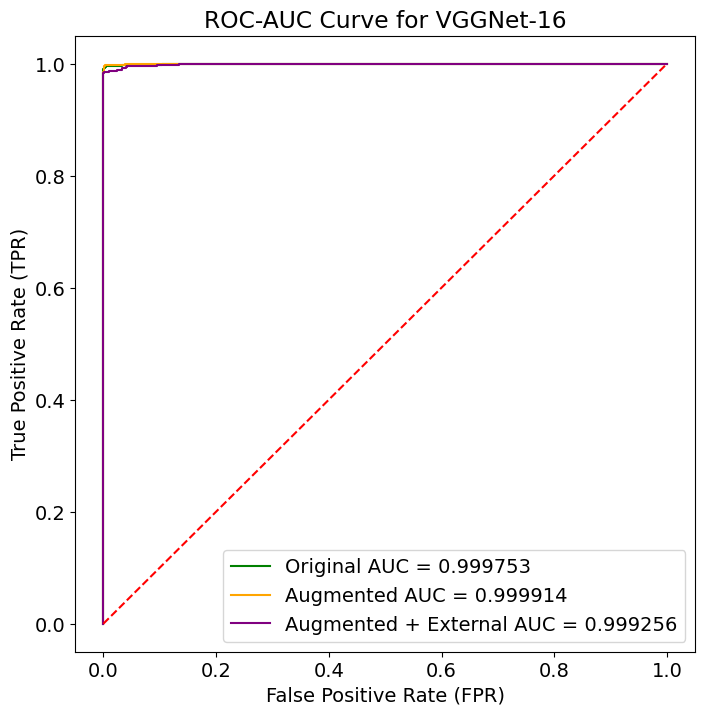

In [ ]:
# Plot ROC-AUC Curve

# get liver probabilities from the test outputs
y_probs_o = torch.nn.functional.softmax(test_outputs_o.cpu(), dim=1).detach().numpy()[:, 1]
y_probs_a = torch.nn.functional.softmax(test_outputs_a.cpu(), dim=1).detach().numpy()[:, 1]
y_probs_d = torch.nn.functional.softmax(test_outputs_d.cpu(), dim=1).detach().numpy()[:, 1]

# plot the curves
y_data = [(y_test_o.cpu().numpy(), y_probs_o, 'green', 'Original'), (y_test_a.cpu().numpy(), y_probs_a, 'orange', 'Augmented'), (y_test_d.cpu().numpy(), y_probs_d, 'purple', 'Augmented + External')]
auc_roc_curves(y_data, "VGGNet-16")

In [ ]:
# Original
create_confusion_matrix(y_test_o.cpu().numpy(), y_pred_o, title="- VGGNet-16 Original")

In [ ]:
# Original + Augmented Confusion Matrix
create_confusion_matrix(y_test_a.cpu().numpy(), y_pred_a, title="- VGGNet-16 Augmented")

In [ ]:
# Original + Augmented + External Confusion Matrix
create_confusion_matrix(y_test_d.cpu().numpy(), y_pred_d, title="- VGGNet-16 Augmented + External")